# Training a Faster R-CNN

This is a step-by-step tutroial to train the Faster RCNN using Facebook's Detectron2. Please follow the directions in this notebook to train your own Faster RCNN. Where necessary, comments have been provided to explain the code.

## Import Standard Libraries

In [1]:
import os
import re
import json
import pprint
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow
import cv2

## Import Detectron 2 Libraries

In [2]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

import torch, torchvision
#opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.6.0%2Bcu101-cp37-cp37m-linux_x86_64.whl
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: torchaudio 0.7.2 has requirement torch==1.7.1, but you'll have torch 1.6.0+cu101 which is incompatible.


In [3]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Mount Google Drive

In this notebook we get our data from google drive. You may also choose to get the data from Google Cloud Platform or locally - depending on how your data is stored.

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Navigate to the specific directory in which your data is stored. 

In [5]:
os.chdir('/content/drive/.shortcut-targets-by-id/172HG5ldhhjVNlMDSbaC7GRQK5w86cRO4/yolo_images/proofpoint_data/rcnn')

## Analyse Labels

Identify the JSON files containing the labels. Having the labels in the COCO format is necessary for use with Detectron2. We will later read them to understand the structure and hierarchy.

In [6]:
label_files = []
re_pattern = r'\s*.json$'
for file in os.listdir():
  if re.search(re_pattern, file):
      label_files.append(file)
label_files

['train_img_v4_coco.json', 'test_img_v4_coco.json', 'val_img_v4_coco.json']

We next read in each of the label JSON files and understand the hierarchy of each of them

In [7]:
for f in label_files:
  #p = 'train_img_v4_coco.json'
  with open(f, 'r') as f:
      train_doc = json.loads(f.read())
      images = train_doc['images'][0]
      annotations = train_doc['annotations'][0]
      print (f.name)
      pprint.pprint(images)
      pprint.pprint(annotations)
      print ('\n')

train_img_v4_coco.json
{'file_name': '06566fd8883787f109f0d9f63950505c1dea4ae51c7f3b32d3c1c5a17e5be5cb.png',
 'height': 1440,
 'id': '06566fd8883787f109f0d9f63950505c1dea4ae51c7f3b32d3c1c5a17e5be5cb',
 'width': 2560}
{'area': 24768,
 'bbox': [43, 78, 344, 72],
 'category_id': 1,
 'id': 1,
 'ignore': 0,
 'image_id': '06566fd8883787f109f0d9f63950505c1dea4ae51c7f3b32d3c1c5a17e5be5cb',
 'iscrowd': 0,
 'segmentation': []}


test_img_v4_coco.json
{'file_name': '25cc065983881febbda24b8975a7bdf2b621817bf97e1808d6e337c95eb76dc1.png',
 'height': 1440,
 'id': '25cc065983881febbda24b8975a7bdf2b621817bf97e1808d6e337c95eb76dc1',
 'width': 2560}
{'area': 42500,
 'bbox': [330, 29, 250, 170],
 'category_id': 1,
 'id': 1,
 'ignore': 0,
 'image_id': '25cc065983881febbda24b8975a7bdf2b621817bf97e1808d6e337c95eb76dc1',
 'iscrowd': 0,
 'segmentation': []}


val_img_v4_coco.json
{'file_name': 'f0611e5ea0ddac9d9d3ba55a0de5ef16c7858bd32bbc53e1211db376e76b3d75.png',
 'height': 1440,
 'id': 'f0611e5ea0ddac9d9d3ba

In [8]:
q = 'train_img_v4_coco.json'
test_ids = []
with open(q, 'r') as f:
    test_doc = json.loads(f.read())
    test_ids = [item['file_name'] for item in test_doc['images']]

p = 'val_img_v4_coco.json'
train_ids = []
with open(p, 'r') as f:
    train_doc = json.loads(f.read())
    train_ids = [item['file_name'] for item in train_doc['images']]

## Registering our dataset with Detectron2

This step is requried everytime a new colab runtime is initated. We link the labels to the directories in which the actual images are stored. Note that the labels are in the COCO format.

In [9]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("lg_dataset_train", {}, "train_img_v4_coco.json", os.path.join(os.getcwd(), 'train'))
register_coco_instances("lg_dataset_test", {}, "val_img_v4_coco.json", os.path.join(os.getcwd(), 'val'))

In [10]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

'''
  This is a function created to implement data augmentation for Faster RCNN. We couldn't execute this function as it requires > 16 GB of RAM. Moreover, 
  realised that data augmentation does not have that much of an advantage when it comes to logo detection. However, if you want to implement data augmentation
  feel free to use the following custom mapper.
'''

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

'''
  Class used to implement the above custom mapper
'''
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

## Faster RCNN Architecture

The following are all the available model architecutes in the Detectron2 model zoo. Feel free to swap out architectures as you see fit. Note that welve used the ResNeXt 101 + FPN architecure to train our version of the RCNN. 


1.   "COCO-Detection/faster_rcnn_R_50_C4_1x": "137257644/model_final_721ade.pkl"
2.   "COCO-Detection/faster_rcnn_R_50_DC5_1x": "137847829/model_final_51d356.pkl"
3. "COCO-Detection/faster_rcnn_R_50_FPN_1x": "137257794/model_final_b275ba.pkl"
4. "COCO-Detection/faster_rcnn_R_50_C4_3x": "137849393/model_final_f97cb7.pkl"
5. "COCO-Detection/faster_rcnn_R_50_DC5_3x": "137849425/model_final_68d202.pkl"
6. "COCO-Detection/faster_rcnn_R_50_FPN_3x": "137849458/model_final_280758.pkl"
7. "COCO-Detection/faster_rcnn_R_101_C4_3x": "138204752/model_final_298dad.pkl"
8. "COCO-Detection/faster_rcnn_R_101_DC5_3x": "138204841/model_final_3e0943.pkl"
9. "COCO-Detection/faster_rcnn_R_101_FPN_3x": "137851257/model_final_f6e8b1.pkl"
10. "COCO-Detectionfaster_rcnn_X_101_32x8d_FPN_3x":139173657model_final_68b088.pkl"

https://github.com/facebookresearch/detectron2/blob/master/detectron2/model_zoo/model_zoo.py


In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")) #Using a ResNeXt 101 + FPN architecture. 
cfg.DATASETS.TRAIN = ("lg_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 10000 iterations seems good enough for this dataset 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # greater this number, more RAM you'll need
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class - logo. (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) # we used the default trainer. If you want data augmentation, set 'trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
#trainer.train() Uncomment this line if you want to start training the RCNN. 

[04/28 16:01:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


## Model Inference

Faster RCNN automatically creates a folder called 'output' and puts the model weights in that folder. This can later be accessed in order to do model inference. 

In [13]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0009999.pth")  # path to the model we just trained and the name of the file containing final weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()


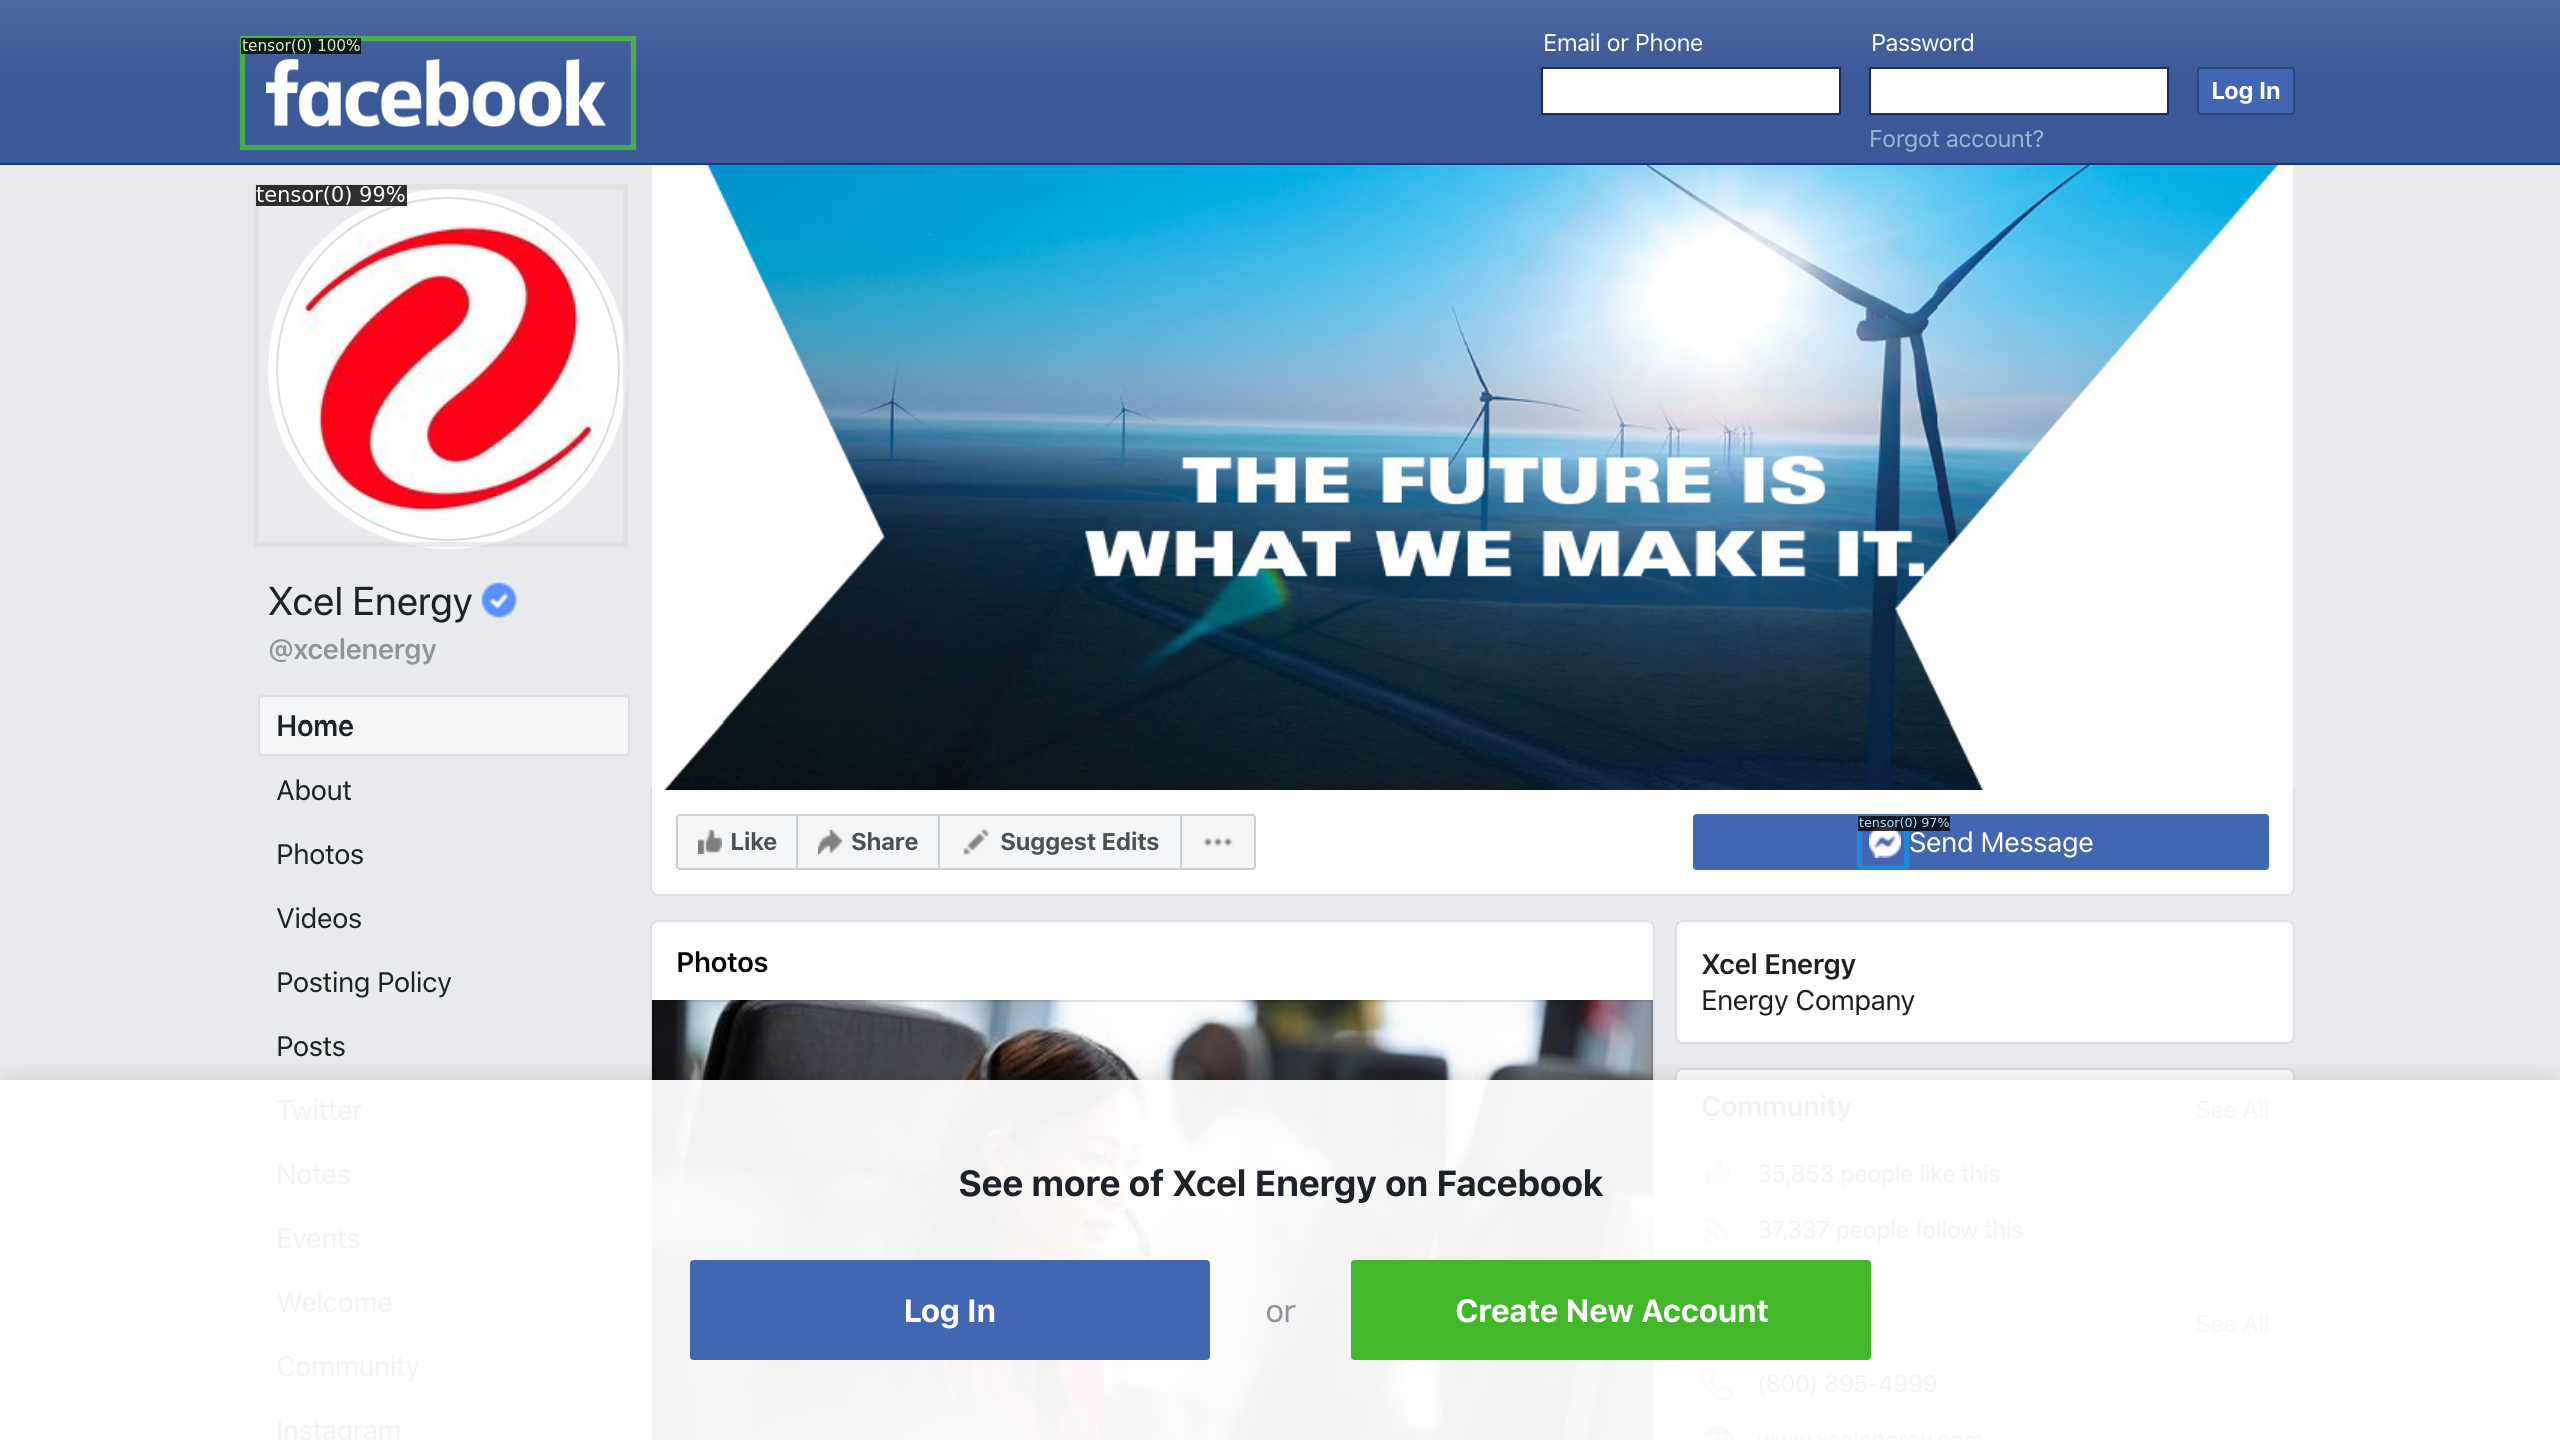

In [14]:
imgs = ['ec9dde7e24b75b5b19ef3c2a0b8a7eb86d92a335e1a18e076f28f3962379e7de.png'] # give specific names of test/val image you want to see the predictions on
from detectron2.utils.visualizer import ColorMode
dataset_dicts = test_ids
for d in imgs:   
    im = cv2.imread(os.path.join(*[os.getcwd(), 'val', d]))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:,:,::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    #print (im.shape)

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("lg_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "lg_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [04/28 16:02:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/28 16:02:32 d2.data.datasets.coco]: Loaded 646 images in COCO format from val_img_v4_coco.json
[04/28 16:02:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    logo    | 2154         |
|            |              |
[04/28 16:02:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/28 16:02:32 d2.data.common]: Serializing 646 elements to byte tensors and concatenating them all ...
[04/28 16:02:32 d2.data.common]: Serialized dataset takes 0.31 MiB
[04/28 16:02:32 d2.evaluation.evaluator]: Start inference on 646 images
[04/28 16:02:37 d2.evaluation.evaluator]: Inference done 11/646. 0.3511 s / img. ETA=0:03:43
[04/28 16:02: